# New name generator

Given a set of real names, create a model that will be able to generate new names

In [1]:
with open("names.txt", "r") as file:
    words = file.read().splitlines()

In [2]:
words[:3]

['emma', 'olivia', 'ava']

## Dummy method: bigram

- split each string into two-letter chunks (bigrams)
- count how many times each bigram combination appears in the dataset
- based on this frequency matrix, create a probability distribution across all bigrams

we'll add a SPECIAL_TOKEN before and after each word to mark start of word and end of word in the frequency matrix. 

In [3]:
SPECIAL_TOKEN = "."
characters = sorted(set(list("".join(words))))
char2id = {char : idx for idx, char in enumerate(characters, start=1)}
char2id[SPECIAL_TOKEN] = 0
id2char = {idx : char for char, idx in char2id.items()}

In [4]:
SHAPE = len(char2id)

In [5]:
import torch

frequencies = torch.zeros(SHAPE, SHAPE, dtype=torch.int)

for word in words:
    characters = [SPECIAL_TOKEN] + list(word) + [SPECIAL_TOKEN]
    for char1, char2 in zip(characters, characters[1:]):
        idx1, idx2 = char2id[char1], char2id[char2]
        frequencies[idx1, idx2] += 1

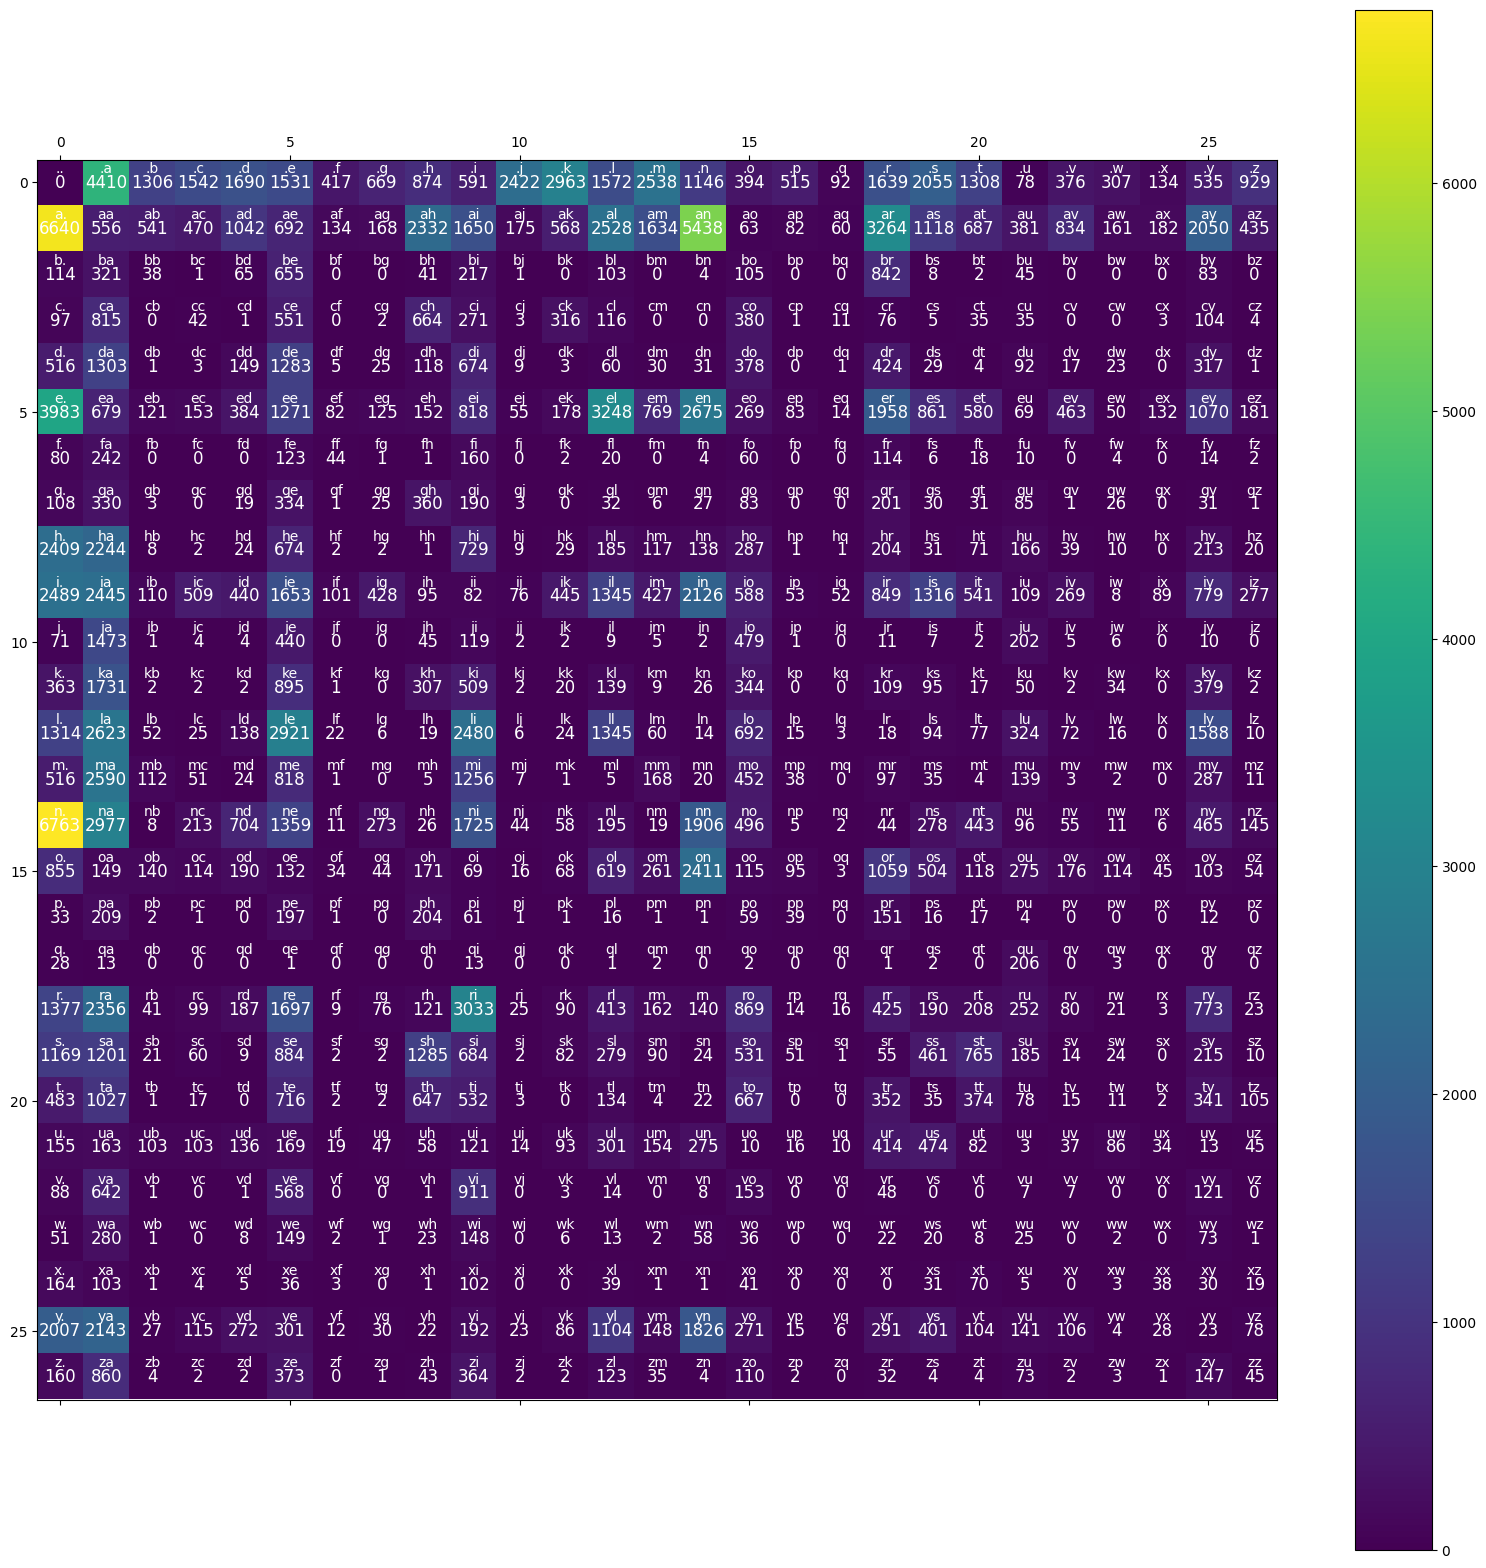

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))

cax = ax.matshow(frequencies, cmap='viridis') 
fig.colorbar(cax)

for i in range(SHAPE):
    for j in range(SHAPE):
        # Show the count value
        label = id2char[i] + id2char[j]
        ax.text(j, i, frequencies[i, j].item(), va='center', ha='center', color='white', fontsize=12)
        # Show the label above the count value
        ax.text(j, i - 0.3, label, va='center', ha='center', color='white', fontsize=10)
plt.show()

In [7]:
probs = (frequencies+1).float()/(frequencies+1).sum(1, keepdims=True) #add 1 so there are no zeros in the probability matrix i.e. no infinite loss

In [8]:
def generate_word(generator, probabilities, id2char=id2char, eos_id=0):
    word = ''
    idx = 0
    while True:
        row_prob = probabilities[idx]
        idx = torch.multinomial(row_prob, num_samples=1, replacement=True, generator=generator).item()
        if idx==eos_id:
            break
        char = id2char[idx]
        word += char
    return word

In [9]:
SEED = 13

generator = torch.Generator().manual_seed(SEED)

for _ in range(10):
    word = generate_word(generator=generator, probabilities=probs)
    print(word)

lai
ko
a
orazon
phlythaloer
i
ja
bb
an
jardeelariyarleraloriouindor


### Why is it so bad? Mb the method isn't working? 
Lets try a baseline - where every sequence has the same prob

In [10]:
uniform_probs = torch.full(size=(SHAPE, SHAPE), fill_value=1/SHAPE, dtype=torch.float)
generator = torch.Generator().manual_seed(13)

for _ in range(10):
    word = generate_word(generator=generator, probabilities=uniform_probs)
    print(word)

lwwukjxxfoiazxxmpnlgtxhqwerwi
yccbbxkqmjsrdgepardyjelqrfxjbboeigqmk
dblhlhtbmpqlggecauggfgqytlmtivxdfgcsc
dmsil
jsb
siayizwsrfwryitc
krd
bsn
tmshewmvkeguukfp
rkvsvyqxzjjij


So this is completely random - i.e. bigram really works - its just a bad method overall :)  

# Evaluation - defining a loss

In [11]:
example = words[0]

# calculate the likelihood of the sequence given probability matrix probs
chars = [SPECIAL_TOKEN] + list(example) + [SPECIAL_TOKEN]
likelihood = 1
log_likelihood = 0
for char1, char2 in zip(chars, chars[1:]):
    idx1, idx2 = char2id[char1], char2id[char2]
    likelihood_sample = probs[idx1, idx2]
    log_likelihood_sample = torch.log(likelihood_sample)
    print(f"Likelihood of {char1}{char2}: {likelihood_sample}")
    likelihood *= likelihood_sample
    print(f"Log Likelihood of {char1}{char2}: {log_likelihood_sample}")
    log_likelihood += log_likelihood_sample
print(f"Likelihood of {example}: {likelihood}")
print(f"Log Likelihood of {example}: {log_likelihood}")
print(f"Averaged Log likelihood of {example} : {log_likelihood/len(chars[1:])}")


Likelihood of .e: 0.047785401344299316
Log Likelihood of .e: -3.0410351753234863
Likelihood of em: 0.03765281289815903
Log Likelihood of em: -3.2793476581573486
Likelihood of mm: 0.025341130793094635
Log Likelihood of mm: -3.6753265857696533
Likelihood of ma: 0.3885140120983124
Log Likelihood of ma: -0.9454260468482971
Likelihood of a.: 0.19583038985729218
Log Likelihood of a.: -1.6305063962936401
Likelihood of emma: 3.4690092434175313e-06
Log Likelihood of emma: -12.57164192199707
Averaged Log likelihood of emma : -2.5143284797668457


For it to be a loss function i.e. the less the better, we invert log likelihood and use negative log likelihood as a loss

Usually we report not the accumulated loss value but the average across all examples. This way we can, for example, compare loss for datasets with different lengths

In [12]:
def calculate_nll(word : str, probabilities: torch.tensor, special_token: str = SPECIAL_TOKEN) -> torch.tensor:
    """Calculate negative log likelihood for given word"""
    chars = [special_token] + list(word) + [special_token]
    loss = 0
    for char1, char2 in zip(chars, chars[1:]):
        idx1, idx2 = char2id[char1], char2id[char2]
        likelihood = probabilities[idx1, idx2]
        log_likelihood = torch.log(likelihood)
        loss += log_likelihood
    return -loss
    

In [13]:
calculate_nll(words[0], probabilities=probs)/(len(words[0])+1) # i.e. 2 letter word is 3 examples: .1, 12, 2.

tensor(2.5143)

In [14]:
# Calculate loss over whole dataset

total_loss = 0
n_examples = 0
for word in words:
    n_examples += (len(word) + 1)
    total_loss += calculate_nll(word, probabilities=probs)

averaged_loss = total_loss/n_examples
print(f"{total_loss=}")
print(f"{averaged_loss=}")

total_loss=tensor(560002.3125)
averaged_loss=tensor(2.4546)


In [15]:
n_examples

228146

## Neural net

Now lets create a simple neural net that will optimize the negative log likelihood loss

In [16]:
# Creating a train dataset


xs, ys = [], []

for word in words:
    chars = [SPECIAL_TOKEN] + list(word) + [SPECIAL_TOKEN]
    for char1, char2 in zip(chars, chars[1:]): #char1 is input and char2 is target
        idx1, idx2 = char2id[char1], char2id[char2]
        xs.append(idx1)
        ys.append(idx2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [17]:
xs

tensor([ 0,  5, 13,  ..., 25, 26, 24])

In [18]:
ys

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [19]:
# Initialize the network - it'll just be a single layer with W
generator = torch.Generator().manual_seed(SEED)
W = torch.randn(size=(SHAPE, SHAPE), requires_grad=True, generator=generator)

In [20]:
import torch.nn.functional as F

# forward pass

x_one_hot = F.one_hot(xs, num_classes=SHAPE).float()
logits = x_one_hot @ W
exp = logits.exp()
outputs = exp/exp.sum(1, keepdims=True)
print(outputs)
print(outputs.sum(1)) # probability distribution for each example

tensor([[0.0352, 0.0330, 0.1107,  ..., 0.0206, 0.0508, 0.0647],
        [0.0038, 0.0338, 0.1115,  ..., 0.0154, 0.0103, 0.2487],
        [0.0993, 0.0511, 0.0166,  ..., 0.0060, 0.0110, 0.0276],
        ...,
        [0.0313, 0.0107, 0.0078,  ..., 0.1118, 0.0458, 0.0188],
        [0.0137, 0.0344, 0.0296,  ..., 0.1667, 0.0121, 0.0827],
        [0.1838, 0.0069, 0.0145,  ..., 0.0090, 0.0456, 0.0118]],
       grad_fn=<DivBackward0>)
tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)


In [21]:
loss = -outputs[torch.arange(len(xs)), ys].log().mean()
loss

tensor(3.8647, grad_fn=<NegBackward0>)

In [22]:
# W.grad
W.grad = None
loss.backward()
W.data += -0.1 * W.grad

In [23]:
# TRAIN!

iterations = 500

for i in range(iterations):
    x_one_hot = F.one_hot(xs, num_classes=SHAPE).float()
    logits = x_one_hot @ W
    exp = logits.exp()
    outputs = exp/exp.sum(1, keepdims=True)
    
    loss = -outputs[torch.arange(len(xs)), ys].log().mean()
    print(loss.item())
    #backward pass
    W.grad = None
    loss.backward()
    
    # update
    W.data += -50 * W.grad
    

3.8637638092041016
3.4532504081726074
3.2144906520843506
3.063908100128174
2.9561080932617188
2.878106117248535
2.8199126720428467
2.774576425552368
2.7381856441497803
2.7084431648254395
2.683847665786743
2.663327217102051
2.646056890487671
2.631380796432495
2.618774175643921
2.6078245639801025
2.598210573196411
2.5896856784820557
2.5820610523223877
2.5751898288726807
2.5689585208892822
2.563278913497925
2.5580787658691406
2.5533008575439453
2.548898458480835
2.544830322265625
2.5410635471343994
2.537567138671875
2.534315824508667
2.531285524368286
2.528455972671509
2.525808572769165
2.5233263969421387
2.520994186401367
2.5187995433807373
2.516730546951294
2.5147764682769775
2.512927770614624
2.511176347732544
2.5095150470733643
2.507936716079712
2.5064361095428467
2.505007743835449
2.5036461353302
2.502347707748413
2.501108407974243
2.4999234676361084
2.498790979385376
2.4977073669433594
2.4966695308685303
2.4956750869750977
2.4947216510772705
2.4938066005706787
2.4929277896881104
2.4

2.4572529792785645
2.4572441577911377
2.457235813140869
2.4572269916534424
2.457218647003174
2.4572103023529053
2.4572019577026367
2.457193613052368
2.4571852684020996
2.457176923751831
2.4571683406829834
2.457160472869873
2.4571523666381836
2.457144260406494
2.4571359157562256
2.457127809524536
2.457119941711426
2.4571120738983154
2.457103967666626
2.4570963382720947
2.4570882320404053
2.457080364227295
2.4570727348327637
2.4570653438568115
2.457057476043701
2.457049608230591
2.4570422172546387
2.4570345878601074
2.457026958465576
2.457019567489624
2.457012176513672
2.4570045471191406
2.4569971561431885
2.4569897651672363
2.456982374191284
2.456975221633911
2.456967830657959
2.456960678100586
2.456953525543213
2.45694637298584
2.4569389820098877
2.4569318294525146
2.4569251537323
2.4569180011749268
2.4569108486175537
2.4569039344787598
2.4568967819213867
2.456890106201172
2.456883192062378
2.456876277923584
2.45686936378479
2.456862688064575
2.4568557739257812
2.4568490982055664
2.456

In [24]:
# We've converged to the same solution :) 

generator = torch.Generator().manual_seed(SEED)

for i in range(10):
    word = ''
    idx = 0
    while True:
        x_one_hot = F.one_hot(torch.tensor([idx]), num_classes=SHAPE).float()
        logits = x_one_hot @ W
        counts = logits.exp()
        p = counts/counts.sum(1, keepdim=True)
        
        idx = torch.multinomial(p, num_samples=1, generator=generator, replacement=True).item()
        if idx == 0:
            break
        word += id2char[idx]
    print(word)

lai
ko
a
orazon
phlythaloer
i
ja
be
an
jardeelariyarleraloriouindor
